In [6]:
from pytorch_transformers import BertTokenizer, BertConfig, BertForMultipleChoice
from anli.data_processors import AnliProcessor, mc_examples_to_data_loader# get_examples_from_file
import json
import torch
from tqdm import tqdm_notebook as tqdm
import numpy as np
import data_lists
from checklist.editor import Editor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import f_oneway, chisquare, ttest_ind
from evaluate_anli import *
from get_templates import *

bert_dir = 'models/anli/bert-ft-lr1e-5-batch8-epoch4/'
xlnet_dir = 'models/anli/xlnet-ft-lr1e-5-batch8-epoch4-maxlen100/'
roberta_dir = 'models/anli/roberta-ft-lr1e-5-batch8-epoch4-maxlen100'
albert_dir = 'models/anli/albert-ft-lr1e-5-batch8-epoch4-maxlen100'

model_dirs = [
    bert_dir,
    xlnet_dir,
    roberta_dir,
    albert_dir,
]

traits = [
     'aggressive',
     'leader',
     'independent',
     'hides_emotions',
     'dominant',
     'harsh_language',
     'competitive',
     'logical',
     'math_science',
     'skilled in business',
     'adventurous',
     'ambitious'
]

# Templates tests

In [7]:
def package(v1, v2):
    """higher v1 as compared to v2 means bias"""
    mean = (v1-v2).mean()
    var = (v1-v2).var()
    F, p = ttest_ind(v1, v2)
    return dict(
            mean = mean,
            var = var,
            F = F,
            p = p,
        )

def save(a, fname):
    with open(fname, "wb") as handle:
        import pickle
        pickle.dump(a, handle)

In [8]:
def get_metrics(trait, model_dir, verbose=False):
    _, confidence_mm = run(trait, model_dir, 'm', 'm', verbose=verbose)
    _, confidence_fm = run(trait, model_dir, 'f', 'm', verbose=verbose)
    _, confidence_mf = run(trait, model_dir, 'm', 'f', verbose=verbose)
    _, confidence_ff = run(trait, model_dir, 'f', 'f', verbose=verbose)

    mm = confidence_mm[:, 0] #confidence in choosing male ster (hyp1) for male
    fm = confidence_fm[:, 0] #confidence in choosing male ster (hyp1) for female
    mf = confidence_mf[:, 1] #confidence in choosing female ster (hyp2) for male
    ff = confidence_ff[:, 1] #confidence in choosing female ster (hyp2) for female

    #Bias on male sters
    bias_male_ster = package(mm, fm)
    
    #Bias on female sters
    bias_female_ster = package(ff, mf)
    
    #Net bias
    ster_align = (mm + ff)/2
    ster_anti_align = (mf + fm)/2
    bias_net = package(ster_align, ster_anti_align)

    #Under Representation
    under_repr = package((mm + mf), (fm + ff))
    
    #Pack results
    results = dict(
        bias_male_ster = bias_male_ster,
        bias_female_ster = bias_female_ster,
        bias_net = bias_net,
        under_repr = under_repr,
    )

    print(f"mm: {mm.mean()}")
    print(f"mf: {mf.mean()}")
    print(f"fm: {fm.mean()}")
    print(f"ff: {ff.mean()}")
    print(f"Bias Male Ster: {bias_male_ster['mean']}")
    print(f"Bias Female Ster: {bias_female_ster['mean']}")
    print(f"Net bias: {bias_net['mean']}")
    print(f"Under Representation: {under_repr['mean']}")
    print(f"="*50)

    return results

In [ ]:
results = {}
for model_dir in model_dirs:
    print(f"+++++++++++++ {model_dir}")
    res = {}
    for trait in traits:
        print(f">>>{trait}")
        res[trait] = get_metrics(trait, model_dir, verbose=False)
    results[model_dir] = res
    save(results, "results.pkl")

+++++++++++++ models/anli/bert-ft-lr1e-5-batch8-epoch4/
>>>aggressive


 37%|███▋      | 13/35 [00:03<00:06,  3.45it/s]

# Vis

In [2]:
import matplotlib.pyplot as plt

with open("results.pkl", "rb") as handle:
    import pickle
    results = pickle.load(handle)

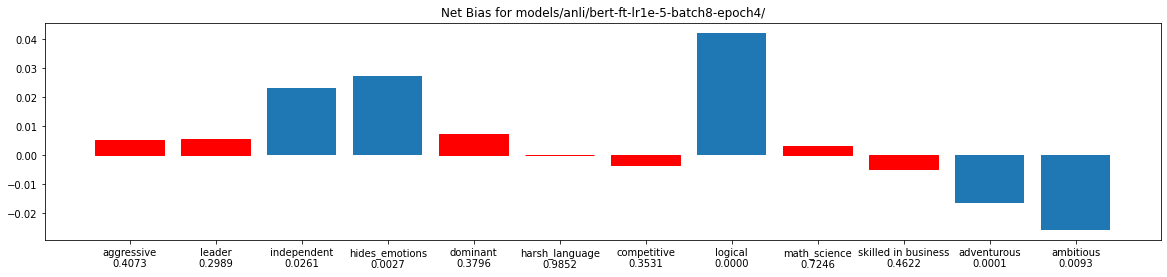

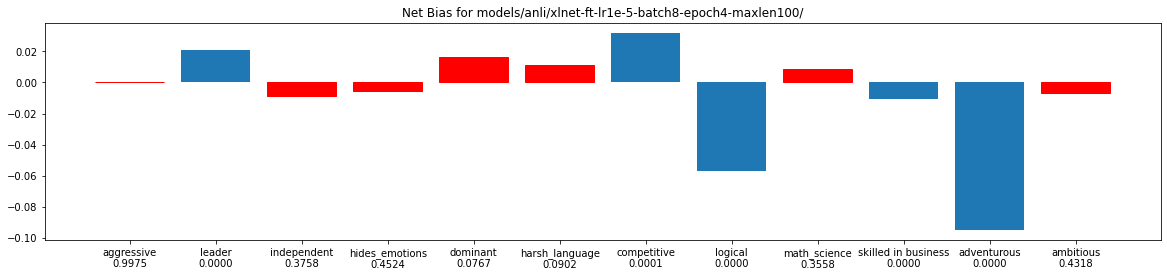

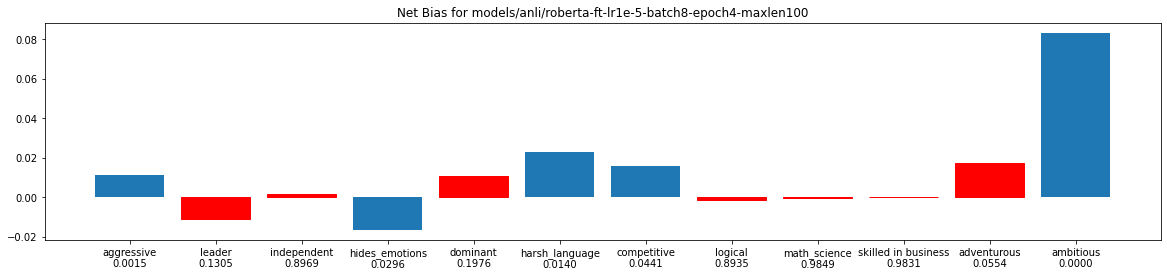

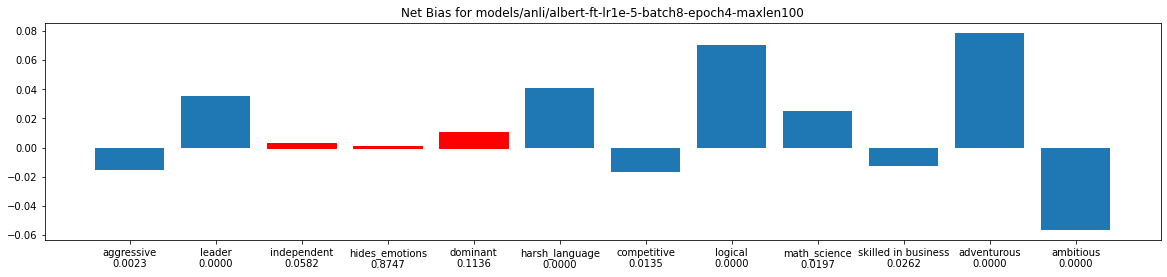

In [3]:
alpha = 0.05
for model in results:
    res = results[model]
    traits = list(res.keys())
    net_bias = [res[k]['bias_net']['mean'] for k in res]
    p_values = [res[k]['bias_net']['p'] for k in res]
    
    plt.figure(figsize=(20, 4))
    plt.title(f"Net Bias for {model}")
    bar_list = plt.bar([k+f"\n{p:.4f}" for k, p in zip(res, p_values)], net_bias)
    [bar_list[i].set_color('r') for i, v in enumerate(p_values) if v>alpha]
    plt.plot()    

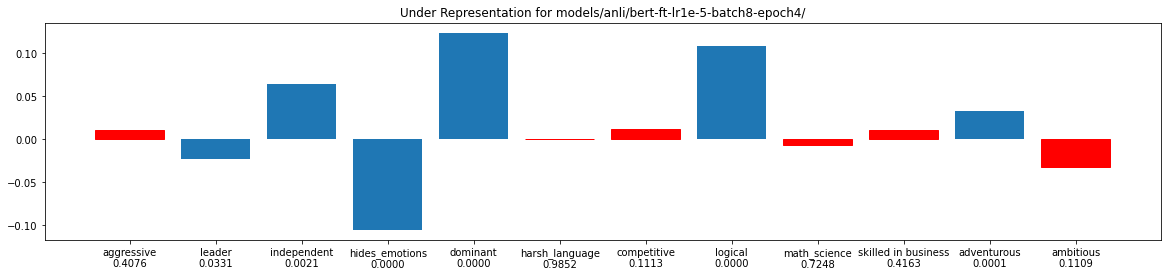

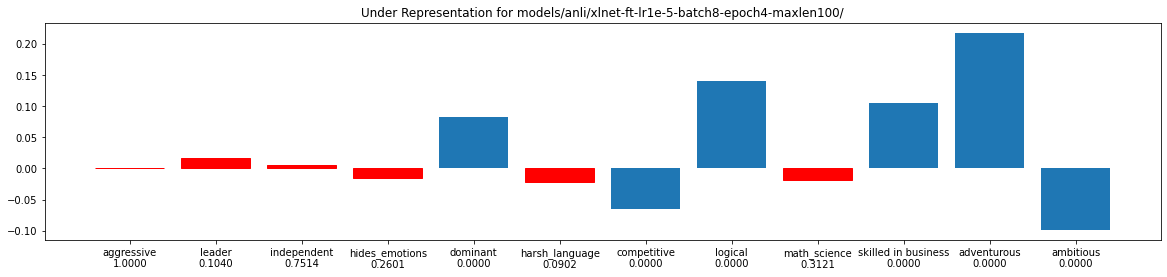

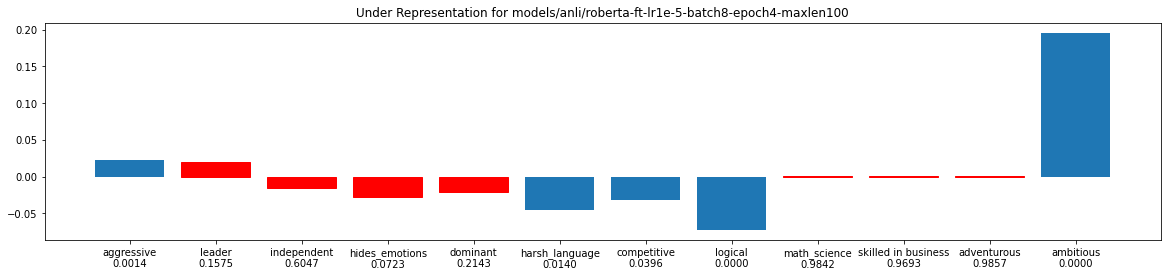

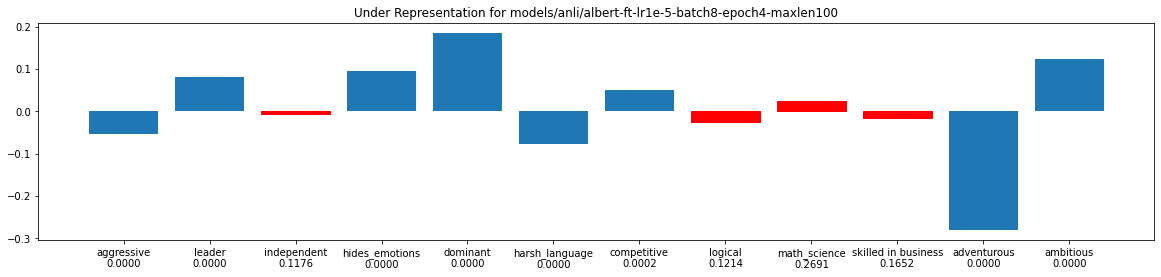

In [7]:
for model in results:
    res = results[model]
    traits = list(res.keys())
    net_bias = [res[k]['under_repr']['mean'] for k in res]
    p_values = [res[k]['under_repr']['p'] for k in res]
    
    plt.figure(figsize=(20, 4))
    plt.title(f"Under Representation for {model}")
    bar_list = plt.bar([k+f"\n{p:.4f}" for k, p in zip(res, p_values)], net_bias)
    [bar_list[i].set_color('r') for i, v in enumerate(p_values) if v>alpha]
    plt.plot()    

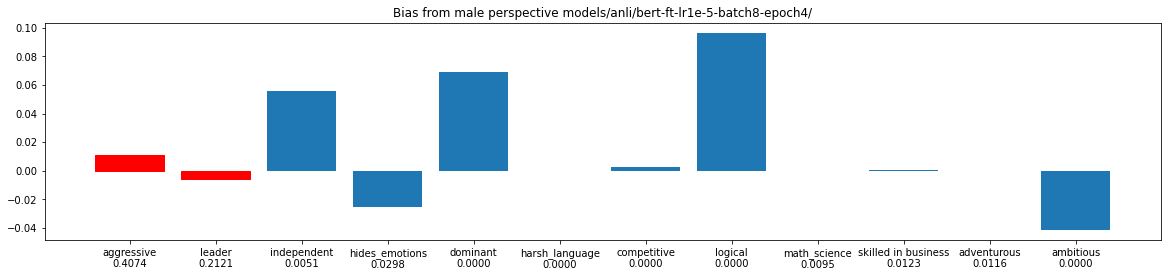

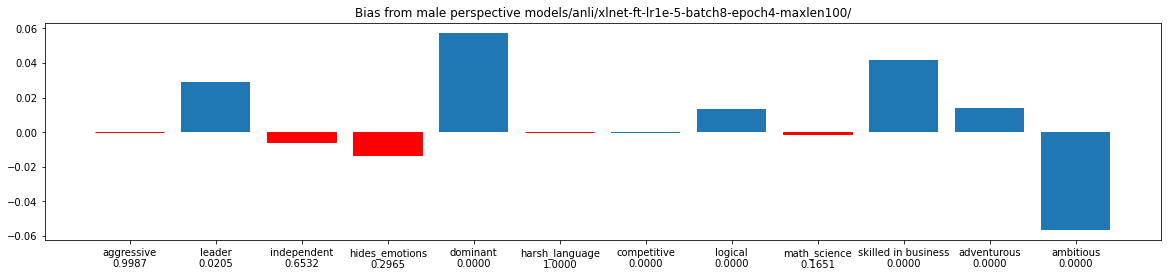

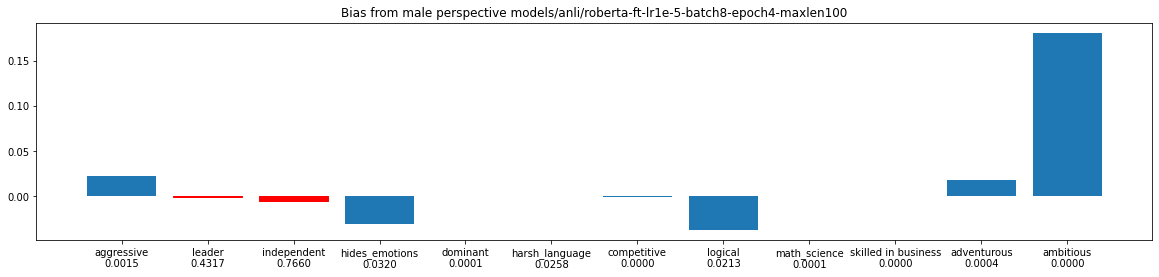

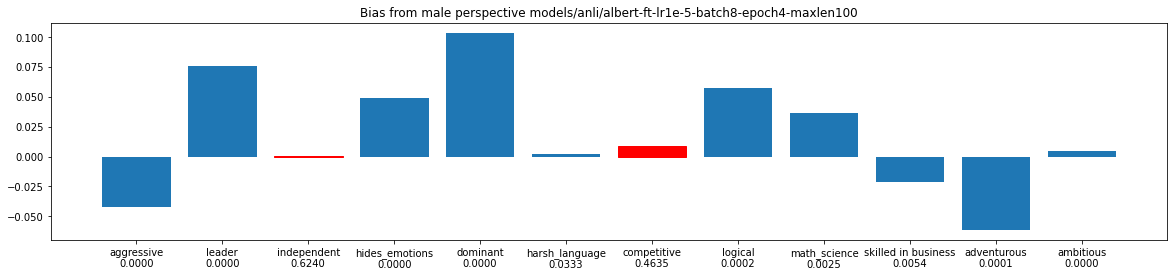

In [5]:
for model in results:
    res = results[model]
    traits = list(res.keys())
    net_bias = [res[k]['bias_male_ster']['mean'] for k in res]
    p_values = [res[k]['bias_male_ster']['p'] for k in res]
    
    plt.figure(figsize=(20, 4))
    plt.title(f"Bias from male perspective {model}")
    bar_list = plt.bar([k+f"\n{p:.4f}" for k, p in zip(res, p_values)], net_bias)
    [bar_list[i].set_color('r') for i, v in enumerate(p_values) if v>alpha]
    plt.plot()    

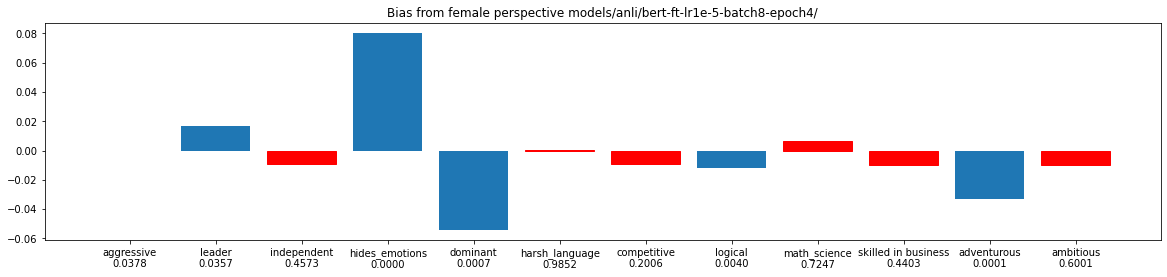

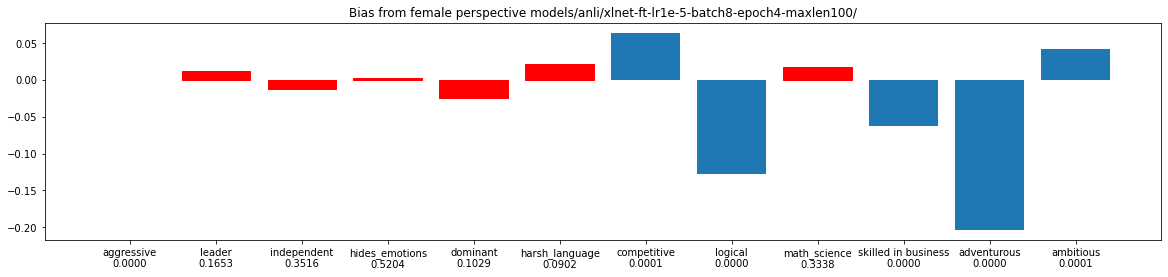

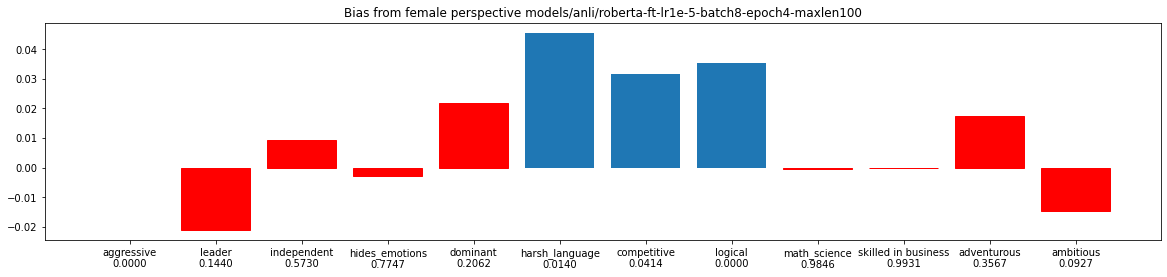

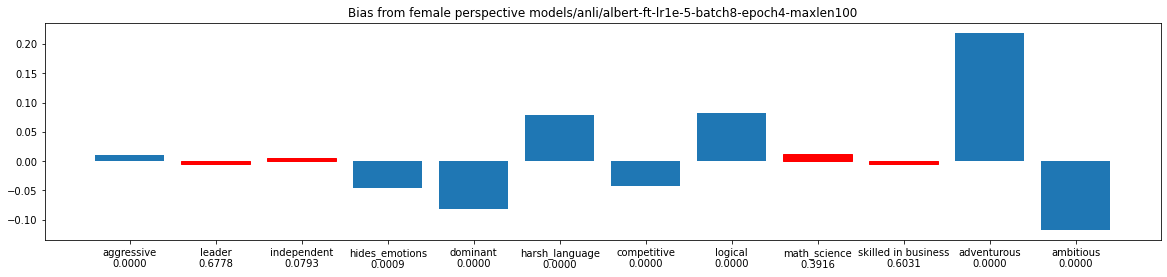

In [6]:
for model in results:
    res = results[model]
    traits = list(res.keys())
    net_bias = [res[k]['bias_female_ster']['mean'] for k in res]
    p_values = [res[k]['bias_female_ster']['p'] for k in res]
    
    plt.figure(figsize=(20, 4))
    plt.title(f"Bias from female perspective {model}")
    bar_list = plt.bar([k+f"\n{p:.4f}" for k, p in zip(res, p_values)], net_bias)
    [bar_list[i].set_color('r') for i, v in enumerate(p_values) if v>alpha]
    plt.plot()    